In [ ]:
import torch
import torchvision.transforms.v2 as v2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from segdac_dev.data.ms3_env_trajectories.data_module import Ms3EnvTrajectoriesDataModule
from segdac_dev.data.sa1b.data_module import Sa1bDataModule
from segdac_dev.visualization.segments import draw_segments_contours

# MS3 Env Traj Dataset

In [ ]:
data_module = Ms3EnvTrajectoriesDataModule(
    trajectories_hdf_file_path="../datasets/trajectory.rgb+segmentation.pd_ee_delta_pos.physx_cpu.h5",
    seed=42,
    train_batch_size=32,
    val_batch_size=32,
    test_batch_size=32,
    val_split_from_train=0.25,
    test_split=0.2,
    train_transform=v2.Compose([
        v2.RandomCrop(size=(224, 224)),
        v2.ToDtype(dtype=torch.float32, scale=True)
    ]),
    eval_transform=v2.Compose([
        v2.Resize(size=(224, 224)),
        v2.ToDtype(dtype=torch.float32, scale=True)
    ]),
    data_loader_num_workers=0
)

data_module.create_datasets()

train_dataloader = data_module.train_dataloader()
val_dataloader = data_module.val_dataloader()
test_dataloader = data_module.test_dataloader()

In [71]:
i = 0
areas = None
for batch in val_dataloader:
    if i > 100:
        break
    i += 1
    if areas is None:
        areas = batch['binary_masks'].sum(dim=(2, 3)).float().squeeze(1)
    else:
        areas = torch.cat([areas, batch['binary_masks'].sum(dim=(2, 3)).float().squeeze(1)])
areas_percent = areas / (224 * 224)

# Segments Statistics

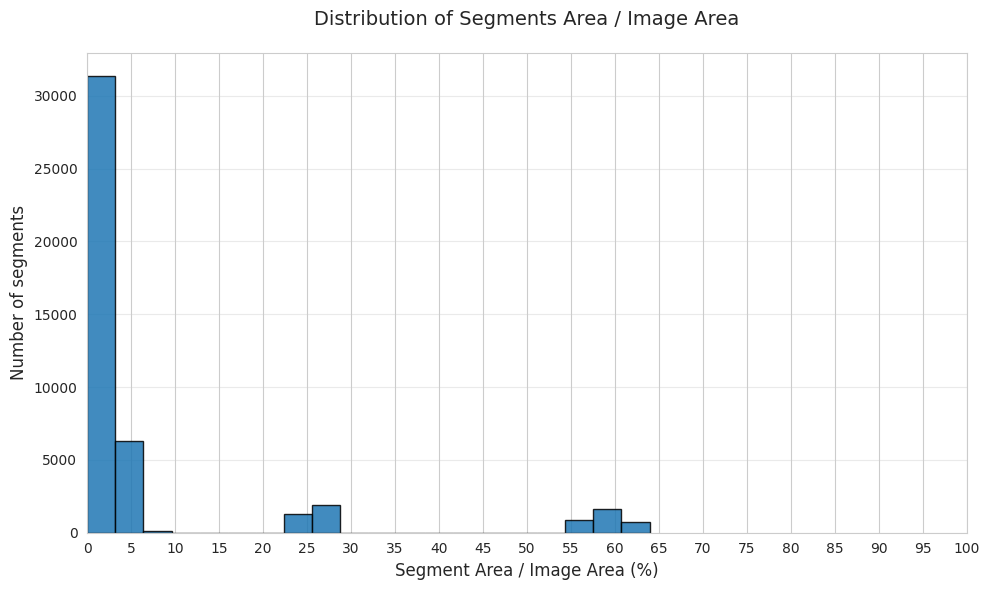

In [72]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

plt.hist(areas_percent.numpy() * 100, bins=20, 
         color='#1f77b4', edgecolor='black', alpha=0.85)

plt.xlabel('Segment Area / Image Area (%)', fontsize=12)
plt.ylabel('Number of segments', fontsize=12)
plt.title('Distribution of Segments Area / Image Area', fontsize=14, pad=20)

plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 5))
plt.gca().set_axisbelow(True)
plt.grid(axis='y', alpha=0.4)

plt.tight_layout()
plt.show()

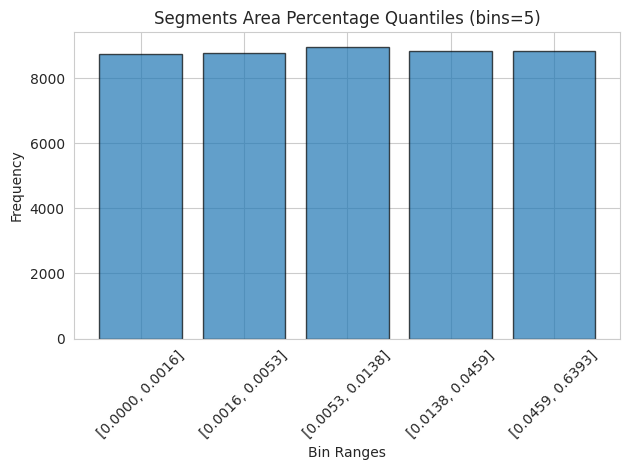

In [73]:
N = 5

edges = np.quantile(areas_percent, np.linspace(0, 1, N + 1))

counts, _ = np.histogram(areas_percent, bins=edges)

bar_positions = np.arange(N)

plt.bar(bar_positions, counts, width=0.8, edgecolor='black', alpha=0.7)

tick_labels = [f"[{edges[i]:.4f}, {edges[i+1]:.4f}]" for i in range(N)]

plt.xticks(bar_positions, tick_labels, rotation=45)

plt.xlabel("Bin Ranges")
plt.ylabel("Frequency")
plt.title(f"Segments Area Percentage Quantiles (bins={N})")
plt.tight_layout()
plt.show()


# SA-1B Dataset

In [ ]:
data_module = Sa1bDataModule(
    data_folder="../datasets/sa1b/",
    seed=42,
    train_batch_size=8,
    val_batch_size=8,
    test_batch_size=8,
    val_split=0.5,
    test_split=0.05,
    train_transform=v2.Compose([
        v2.RandomCrop(size=(224, 224)),
        v2.ToDtype(dtype=torch.float32, scale=True)
    ]),
    eval_transform=v2.Compose([
        v2.Resize(size=(224, 224)),
        v2.ToDtype(dtype=torch.float32, scale=True)
    ]),
    data_loader_num_workers=0,
    use_optimized_dataset=False
)

data_module.create_datasets()

train_dataloader = data_module.train_dataloader()
val_dataloader = data_module.val_dataloader()
test_dataloader = data_module.test_dataloader()

In [8]:
i = 0
areas = []
for batch in val_dataloader:
    if i > 100:
        break
    i += 1
    areas.extend(batch['binary_masks'].sum(dim=(2, 3)).float().squeeze(1).tolist())
areas = torch.as_tensor(areas)
areas_percent = areas / (224 * 224)

# Segments Statistics

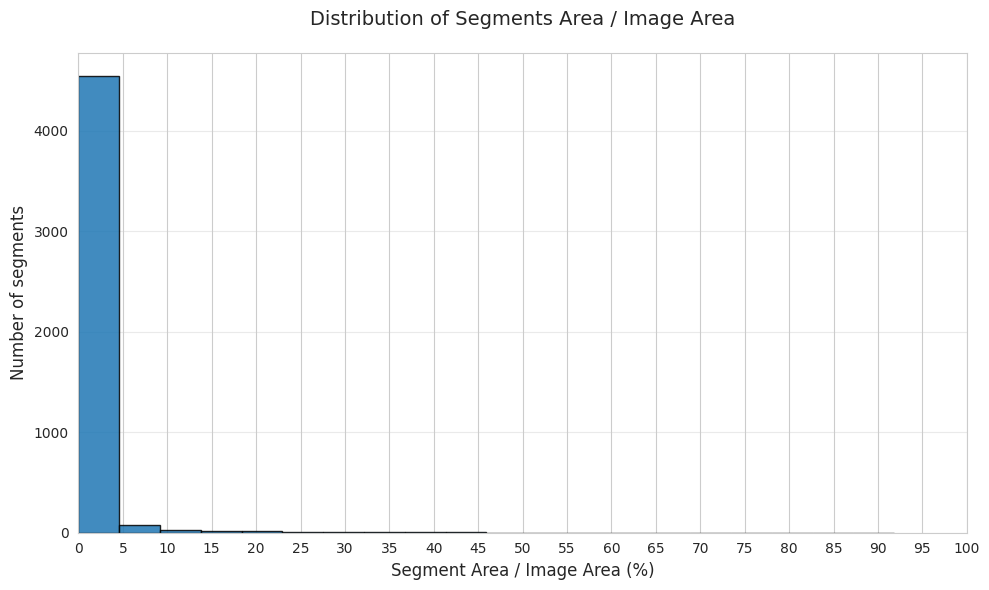

In [9]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

plt.hist(areas_percent.numpy() * 100, bins=20, 
         color='#1f77b4', edgecolor='black', alpha=0.85)

plt.xlabel('Segment Area / Image Area (%)', fontsize=12)
plt.ylabel('Number of segments', fontsize=12)
plt.title('Distribution of Segments Area / Image Area', fontsize=14, pad=20)

plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 5))
plt.gca().set_axisbelow(True)
plt.grid(axis='y', alpha=0.4)

plt.tight_layout()
plt.show()

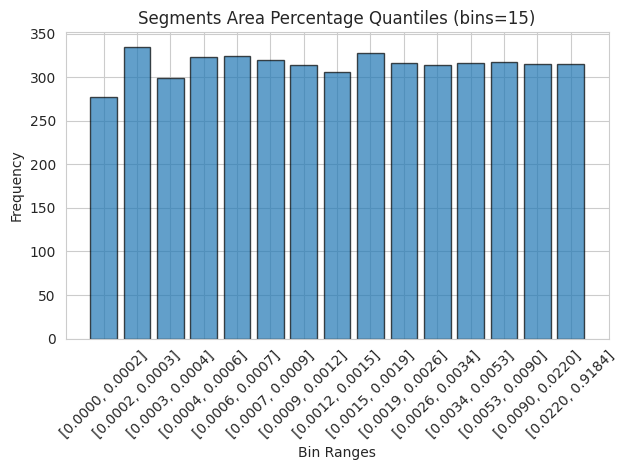

In [12]:
N = 15

edges = np.quantile(areas_percent, np.linspace(0, 1, N + 1))

counts, _ = np.histogram(areas_percent, bins=edges)

bar_positions = np.arange(N)

plt.bar(bar_positions, counts, width=0.8, edgecolor='black', alpha=0.7)

tick_labels = [f"[{edges[i]:.4f}, {edges[i+1]:.4f}]" for i in range(N)]

plt.xticks(bar_positions, tick_labels, rotation=45)

plt.xlabel("Bin Ranges")
plt.ylabel("Frequency")
plt.title(f"Segments Area Percentage Quantiles (bins={N})")
plt.tight_layout()
plt.show()

In [36]:
for batch in val_dataloader:
    break

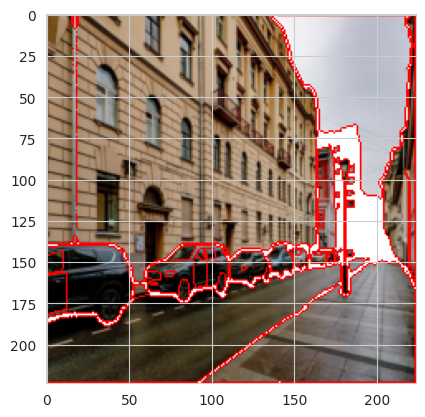

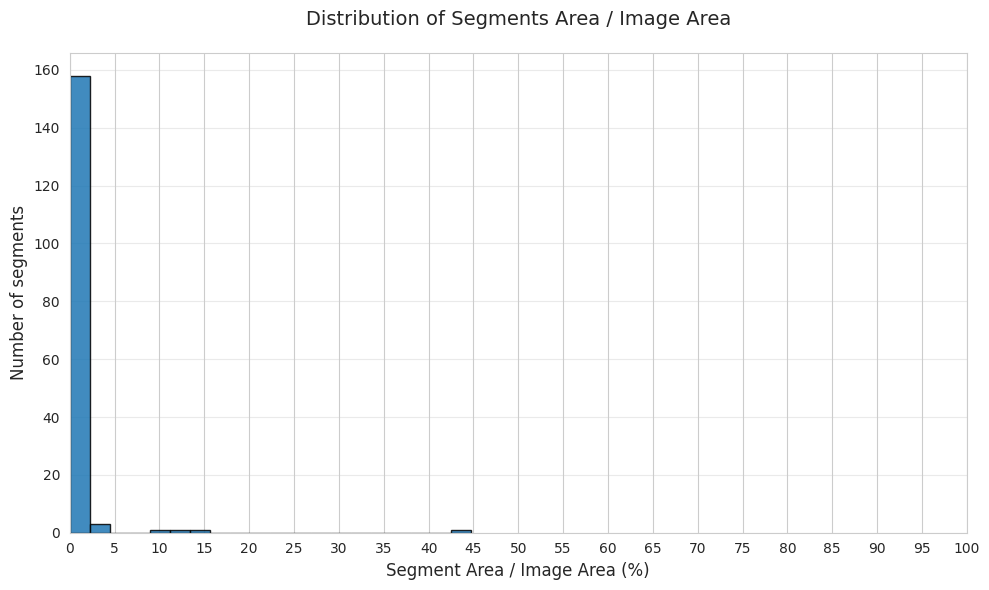

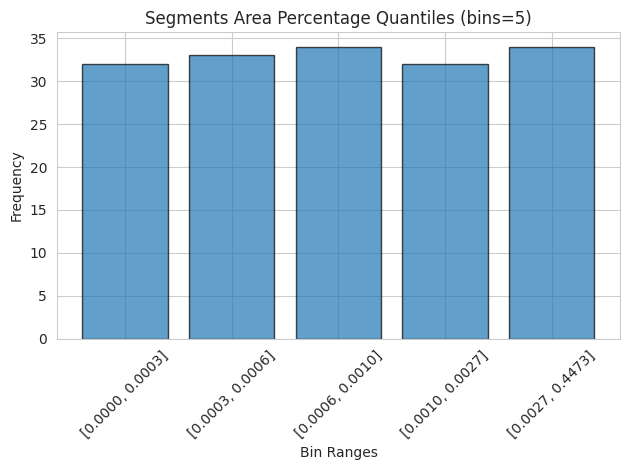

In [68]:
image_id = batch['image_ids'].unique()[0].item()
seg_contours = draw_segments_contours(batch,image_id=image_id, no_prediction_fill_value = 255, scale = True, draw_bboxes = False)
plt.imshow(seg_contours)
plt.show()
segs_areas = batch[batch['image_ids'] == image_id]['binary_masks'].sum(dim=(2, 3)).float().squeeze(1)
segs_areas_percent = segs_areas / (batch['binary_masks'].shape[-2] * batch['binary_masks'].shape[-1])

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

plt.hist(segs_areas_percent.numpy() * 100, bins=20, 
         color='#1f77b4', edgecolor='black', alpha=0.85)

plt.xlabel('Segment Area / Image Area (%)', fontsize=12)
plt.ylabel('Number of segments', fontsize=12)
plt.title('Distribution of Segments Area / Image Area', fontsize=14, pad=20)

plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 5))
plt.gca().set_axisbelow(True)
plt.grid(axis='y', alpha=0.4)

plt.tight_layout()
plt.show()

N = 5

edges = np.quantile(segs_areas_percent, np.linspace(0, 1, N + 1))

counts, _ = np.histogram(segs_areas_percent, bins=edges)

bar_positions = np.arange(N)

plt.bar(bar_positions, counts, width=0.8, edgecolor='black', alpha=0.7)

tick_labels = [f"[{edges[i]:.4f}, {edges[i+1]:.4f}]" for i in range(N)]

plt.xticks(bar_positions, tick_labels, rotation=45)

plt.xlabel("Bin Ranges")
plt.ylabel("Frequency")
plt.title(f"Segments Area Percentage Quantiles (bins={N})")
plt.tight_layout()
plt.show()

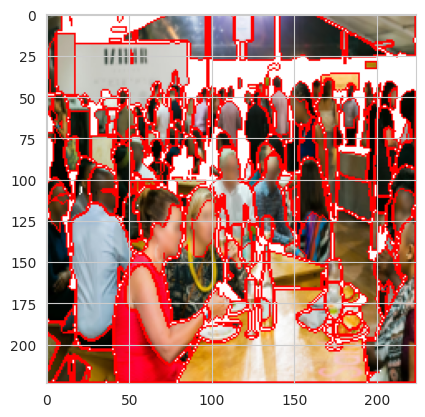

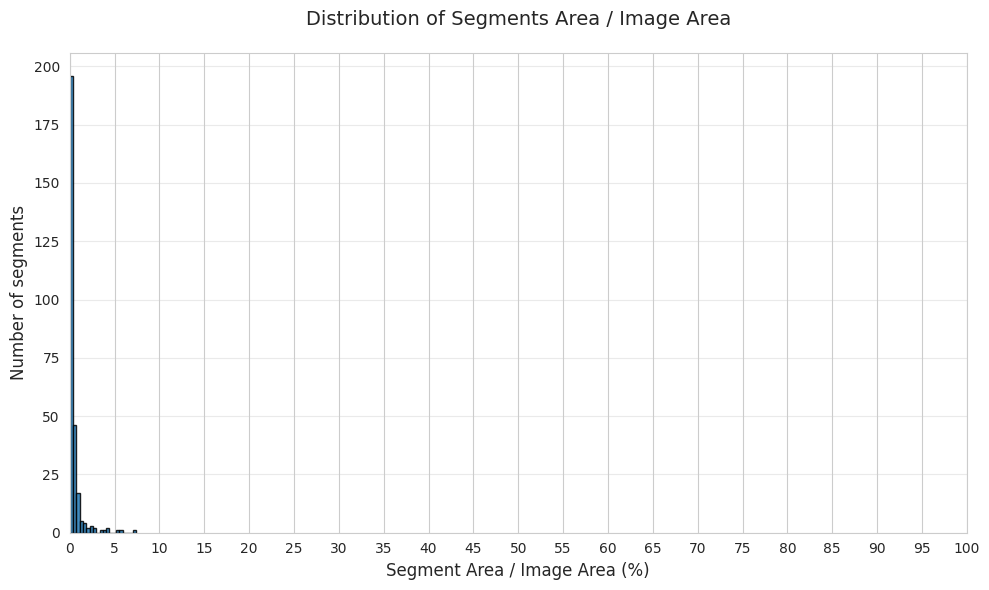

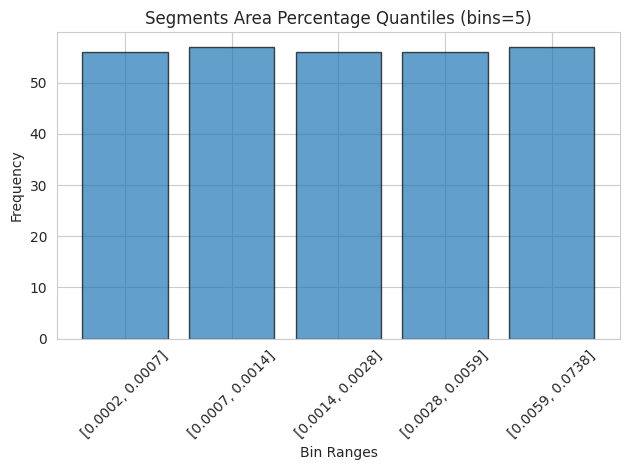

In [ ]:
image_id = batch['image_ids'].unique()[7].item()
seg_contours = draw_segments_contours(batch,image_id=image_id, no_prediction_fill_value = 255, scale = True, draw_bboxes = False)
plt.imshow(seg_contours)
plt.show()
segs_areas = batch[batch['image_ids'] == image_id]['binary_masks'].sum(dim=(2, 3)).float().squeeze(1)
segs_areas_percent = segs_areas / (batch['binary_masks'].shape[-2] * batch['binary_masks'].shape[-1])

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

plt.hist(segs_areas_percent.numpy() * 100, bins=20, 
         color='#1f77b4', edgecolor='black', alpha=0.85)

plt.xlabel('Segment Area / Image Area (%)', fontsize=12)
plt.ylabel('Number of segments', fontsize=12)
plt.title('Distribution of Segments Area / Image Area', fontsize=14, pad=20)

plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 5))
plt.gca().set_axisbelow(True)
plt.grid(axis='y', alpha=0.4)

plt.tight_layout()
plt.show()

N = 5

edges = np.quantile(segs_areas_percent, np.linspace(0, 1, N + 1))

counts, _ = np.histogram(segs_areas_percent, bins=edges)

bar_positions = np.arange(N)

plt.bar(bar_positions, counts, width=0.8, edgecolor='black', alpha=0.7)

tick_labels = [f"[{edges[i]:.4f}, {edges[i+1]:.4f}]" for i in range(N)]

plt.xticks(bar_positions, tick_labels, rotation=45)

plt.xlabel("Bin Ranges")
plt.ylabel("Frequency")
plt.title(f"Segments Area Percentage Quantiles (bins={N})")
plt.tight_layout()
plt.show()